In [1]:
library(cowplot)
library(magrittr)
library(igraph)
suppressPackageStartupMessages(library(ggnetwork))
library(tidygraph)
library(tidyverse)

results <- '../results/'
data <- '../data/'

tumors <- c('ALL', 'AML')
ppiPalette = c("Gained in cases" = "#91cf60", "Lost in cases" = "#ef3b2c", 
               "Unaffected" = "#d9d9d9", "Affected" = "#fe9929")
driverPalette = c('Yes' = '#bcbddc', 'No' = 'white')

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph’:

    groups

The following object is masked from ‘package:stats’:

    filter

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks magrittr::

In [2]:
plot_net <- function(net) {
    ggnetwork(net) %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = "grey50") +
        geom_nodes() +
        theme_blank()
}

In [3]:
switches <- lapply(tumors, function(t) paste0(results, t, '/main_switches.tsv')) %>%
       lapply(read_tsv, col_types = 'ccccciiiicci') %>%
       bind_rows
               
only_switches <- select(switches, Experiment, Symbol, Control_transcript, Case_transcript, Driver)
ppi <- lapply(tumors, function(t) paste0(results, t, '/ppi_analysis.tsv')) %>%
    lapply(read_tsv, col_types = 'cccccccciiiccc') %>%
    bind_rows %>%
    inner_join(only_switches) %>%
    mutate(What = gsub('_', ' ', What))

Joining, by = c("Experiment", "Control_transcript", "Case_transcript")


Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Loading required package: sna
Loading required package: statnet.common

Attaching package: ‘statnet.common’

The following object is masked from ‘package:base’:

    order

Loading required package: network
network: Classes for Relational Data
Version 1.13.0.1 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


Attaching package: ‘network’

The following objects are masked from ‘package:igraph’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.

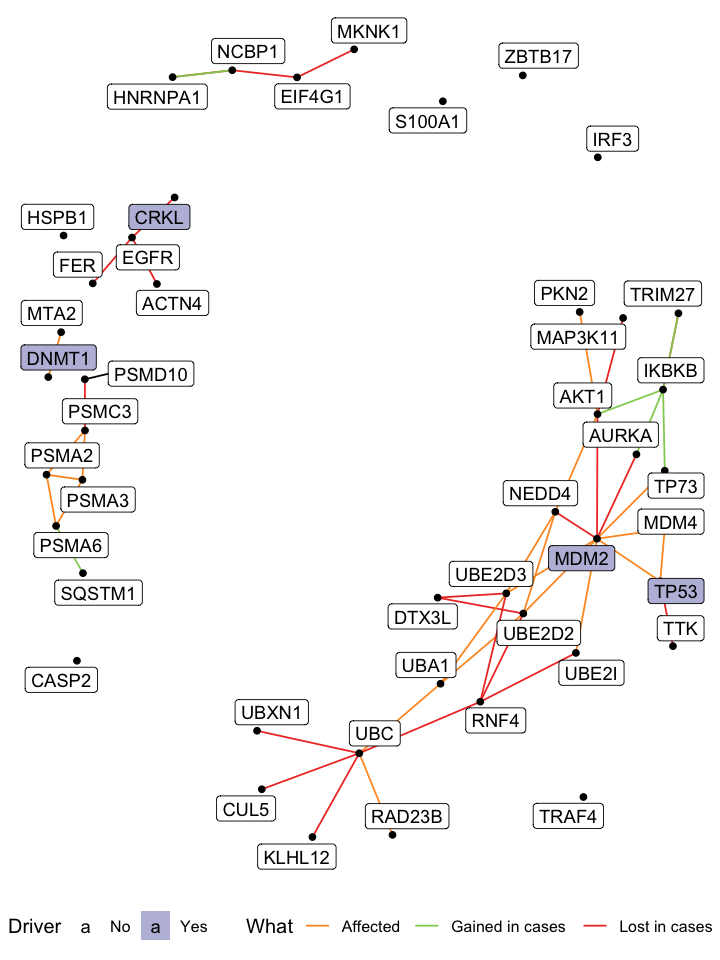

In [4]:
net <- graph_from_data_frame(select(ppi, Symbol, Other_symbol, What), 
                             directed = FALSE) %>%
    as_tbl_graph
class(net) <- c('igraph', 'tbl_graph')

drivers <- filter(only_switches, Driver == 'Foreign driver' | Driver == 'Tumor-specific driver')

options(repr.plot.width=6, repr.plot.height=8)
net %>%
    activate(edges) %>%
    filter(What != 'Unaffected') %>%
    activate(nodes) %>%
    mutate(Driver = ifelse(name %in% drivers$Symbol, 'Yes', 'No')) %>%
    filter(centrality_degree() > 15) %>%
    filter(!node_is_isolated()) %>%
    ggnetwork %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(color = What)) +
        geom_nodes() +
        geom_nodelabel_repel(aes(label = vertex.names, fill = Driver)) +
        theme_blank() +
        scale_color_manual(values = ppiPalette) +
        scale_fill_manual(values = driverPalette) +
        theme(legend.position = 'bottom')